In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import SMART_Funcs as SF

# Flanker

In [26]:
fl = pd.read_csv('flanker_all.csv')

# some data cleaning
fl['PT'] = (1000*(fl['forcedRT_resp.rt']-fl['target_onset'])).astype(int)
fl['acc'] = fl['forcedRT_resp.corr']

#fl = fl[fl.ontime=='Ontime']
fl = fl[(fl.PT >= 0) & (fl.PT <= 1000)]

wide_fl = fl.pivot_table(values=['PT','acc'], index='participant', columns='trial_type', aggfunc=tuple)
# rename column names
wide_fl.columns = [f'{x}_{y}' for x,y in wide_fl.columns]
# convert each cell to np array
wide_fl[['PT_C','PT_I','acc_C','acc_I']] = wide_fl[['PT_C','PT_I','acc_C','acc_I']].applymap(np.array)

# randomly sample some participants
#wide_fl = wide_fl.iloc[:10]

# reset index
wide_fl.reset_index(inplace=True)

C:\Users\Hans Cheng\AppData\Local\Temp\ipykernel_12712\4066202406.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  fl = pd.read_csv('flanker_all.csv')


Text(0.5, 1.0, 'PT = RT - target onset')

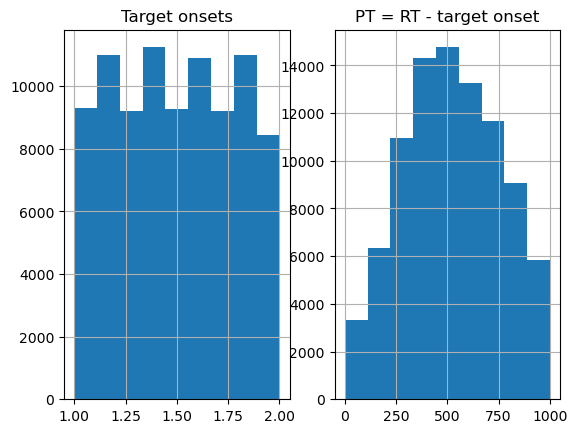

In [54]:
fig, (ax1, ax2) = plt.subplots(1,2)
fl.target_onset.hist(bins=np.linspace(1,2,10), ax=ax1)
fl.PT.hist(bins=np.linspace(0,1000,10),ax=ax2)
ax1.set_title('Target onsets')
ax2.set_title('PT = RT - target onset')

In [201]:
from SMARTClass import SMART

# Settings
data = wide_fl
depVar1 = 'acc_I'
timeVar1 ='PT_I'
depVar2 = 'acc_C'
timeVar2 = 'PT_C'
krnSize = 30
minTime = 1
maxTime = 1001
stepTime = 1
nPerm = 1000
baseline = 0.5
sigLevel = 0.05
nJobs = 16
binary = True

## Run SMART

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:  1.4min remaining:  3.3min
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:  1.5min remaining:  1.5min
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:  1.5min remaining:   39.6s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:  1.5min finished


95.43292093276978


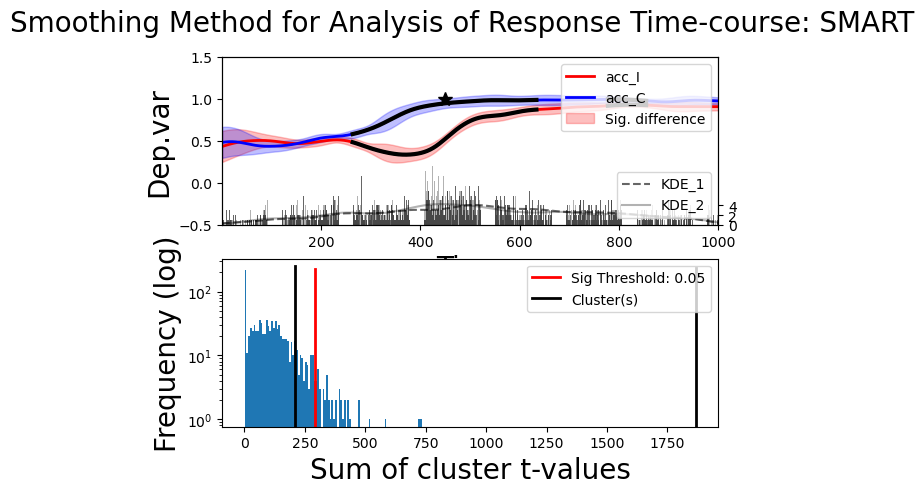

In [202]:
# paired sample test
t = time.time()
pairedSamp = SMART(data, depVar1, timeVar1, depVar2, timeVar2)
pairedSamp.runSmooth(krnSize, minTime, maxTime, stepTime)
pairedSamp.runPermutations(nPerm, nJobs=nJobs, binary=binary)
pairedSamp.runStats(sigLevel)
pairedSamp.runPlot()
print(time.time() - t)

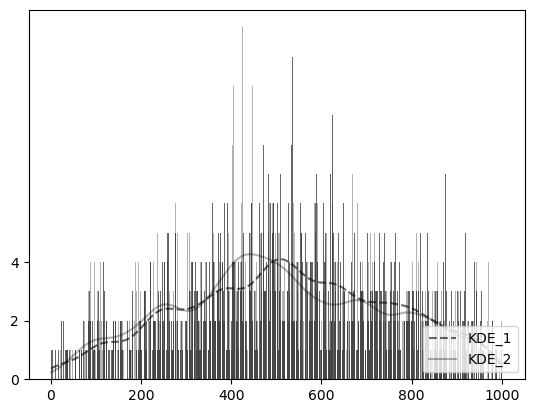

In [240]:
fig, ax = plt.subplots()
sTimes1, unqT1, countT1 = SF.getKDE(np.hstack(data.PT_I),pairedSamp.timeVect, krnSize)
sTimes2, unqT2, countT2 = SF.getKDE(np.hstack(data.PT_C),pairedSamp.timeVect, krnSize)
maxT = np.max(np.hstack([sTimes1, sTimes2]))*8
ax.plot(pairedSamp.timeVect, sTimes1, '--k', alpha = 0.6)
ax.plot(pairedSamp.timeVect, sTimes2, '-k', alpha = 0.3)
ax.bar(unqT1, countT1, color='k', alpha = 0.6)
ax.bar(unqT2, countT2, color='k', alpha = 0.3)
#ax.set_ylim(0, pairedSamp.maxT)
ax.legend(['KDE_1', 'KDE_2'],loc=4)    
ax.set_yticks(np.linspace(0,np.max(np.hstack([sTimes1, sTimes2])),3, dtype=int))

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:  1.3min remaining:  3.1min
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:  1.4min remaining:  1.4min
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:  1.4min remaining:   36.1s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:  1.5min finished


89.01429677009583


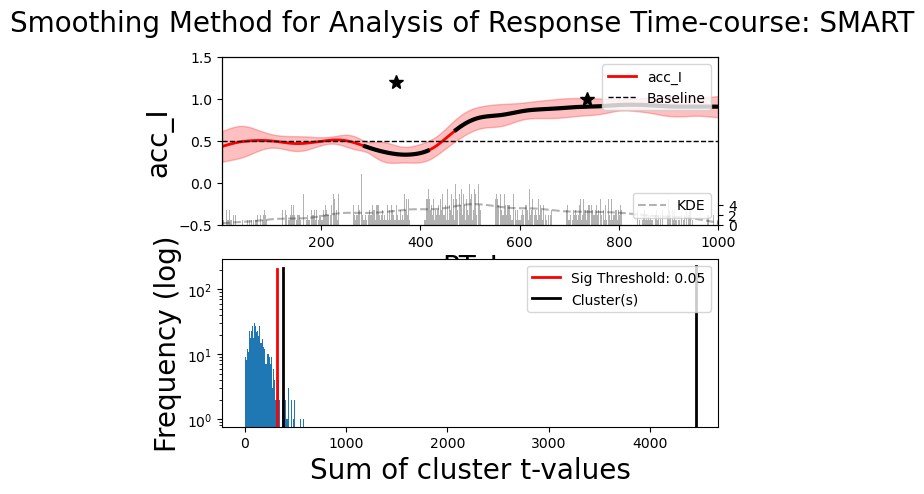

In [203]:
# one sample test vs baseline
t = time.time()
oneSamp = SMART(data, depVar1, timeVar1)
oneSamp.runSmooth(krnSize, minTime, maxTime, stepTime)
oneSamp.runPermutations(nPerm, baseline, nJobs, binary)
oneSamp.runStats(sigLevel)
oneSamp.runPlot()
print(time.time() - t)

## Plotting

Text(0, 0.5, 'Acc')

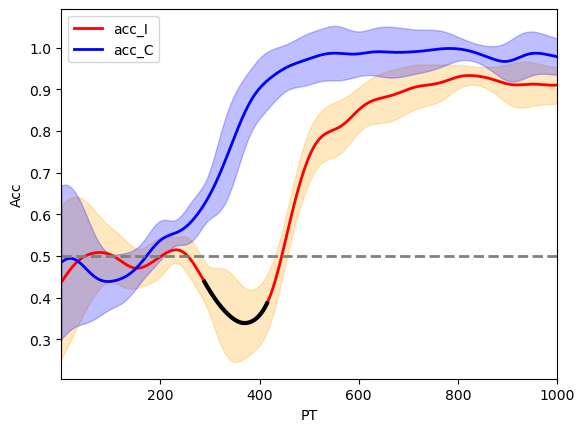

In [231]:
fig, (ax1) = plt.subplots(1,1)
lw = 2
# Plot smoothed data
ax1.plot(pairedSamp.timeVect, pairedSamp.weighDv1Average, '-r', linewidth=lw)
ax1.plot(pairedSamp.timeVect, pairedSamp.weighDv2Average, '-b', linewidth=lw)
ax1.plot(pairedSamp.timeVect, [0.5]*len(pairedSamp.timeVect), color='grey', linestyle='--', linewidth=lw)

# Plot confidence intervals
ax1.fill_between(pairedSamp.timeVect, pairedSamp.weighDv1Average-pairedSamp.conf95, pairedSamp.weighDv1Average+pairedSamp.conf95, color='orange', alpha=0.25)
ax1.fill_between(pairedSamp.timeVect, pairedSamp.weighDv2Average-pairedSamp.conf95, pairedSamp.weighDv2Average+pairedSamp.conf95, color='blue', alpha=0.25)

# Plot significant time points (incongruent trials below 50%)
for ind, i in enumerate(oneSamp.sigCL):
    if oneSamp.sumTvals[ind] >= oneSamp.sigThres:
        if ind == 0:
            ax1.plot(oneSamp.timeVect[i], oneSamp.weighDv1Average[i], '-k', linewidth=lw*1.5)
            
ax1.set_xlim(pairedSamp.timeMin, pairedSamp.timeMax-1)
#ax1.set_ylim(0, 1.1)
ax1.legend([pairedSamp.dv1, pairedSamp.dv2],loc='best')
ax1.set_xlabel('PT', fontsize=10)
ax1.set_ylabel('Acc', size=10)

# ColSing

In [180]:
# long to wide
wide_df = df.pivot_table(values=['PT','target','distractor','other'], index=['participant','Condition'], aggfunc=tuple)
# convert each cell to np array
wide_df[['PT','target','distractor','other']] = wide_df[['PT','target','distractor','other']].applymap(np.array)
# reset index
wide_df.reset_index(inplace=True)

C:\Users\Hans Cheng\Documents\GitHub\SMART\SMART_Funcs.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights /= np.nansum(weights, axis=1, keepdims=True)
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   4 out of  27 | elapsed:   32.0s remaining:  3.1min
[Parallel(n_jobs=16)]: Done   8 out of  27 | elapsed:   44.2s remaining:  1.8min
[Parallel(n_jobs=16)]: Done  12 out of  27 | elapsed:   50.7s remaining:  1.1min
[Parallel(n_jobs=16)]: Done  16 out of  27 | elapsed:  1.1min remaining:   43.7s
[Parallel(n_jobs=16)]: Done  20 out of  27 | elapsed:  1.1min remaining:   23.9s
[Parallel(n_jobs=16)]: Done  24 out of  27 | elapsed:  1.2min remaining:    9.0s
[Parallel(n_jobs=16)]: Done  27 out of  27 | elapsed:  1.3min finished


81.23859763145447


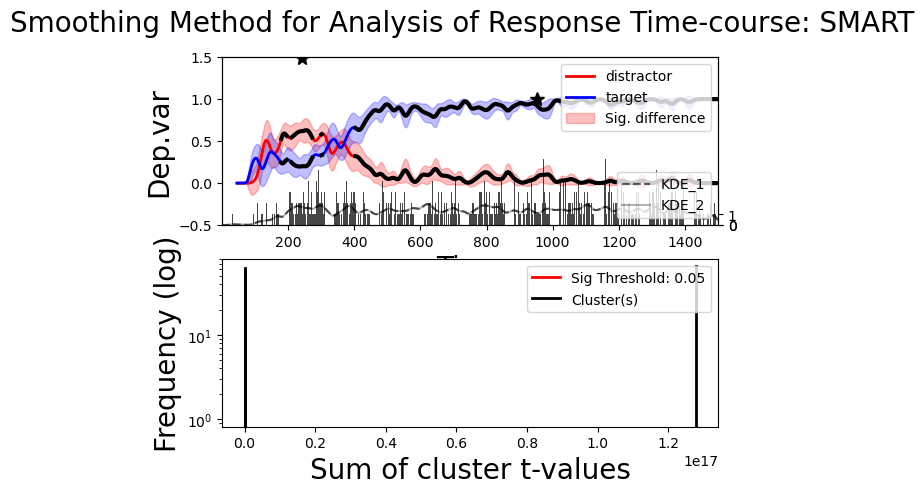

In [190]:
t = time.time()
pairedSamp = SMART(data, depVar1, timeVar1, depVar2, timeVar2)
pairedSamp.runSmooth(krnSize, minTime, maxTime, stepTime)
pairedSamp.runPermutations(nPerm, nJobs=nJobs, binary=binary)
pairedSamp.runStats(sigLevel)
pairedSamp.runPlot()
print(time.time() - t)